In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Create data sets for comaprison
from ipynb.fs.defs.datasets import N_DIM, N_POINTS, default_sets

# BLOCKS = [5, 4, 1]
#BLOCKS = [1] * N_DIM
BLOCKS = [20,10]

N_DIM = np.sum(BLOCKS)
datasets = default_sets(N_DIM, type="diagblock", blocks=BLOCKS)

30


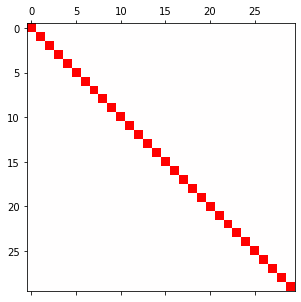

In [3]:
# Projetion onto subspace

#A = np.array(
#    [
#        # 4D
#        # [-1, 0, 0, 1, -1, 0, 1, 0, 0, 0],
#        # [0, -1, 0, 1, 1, 0, 0, 1, 0, 0],
#        # [0, 0, -1, 0, 0, 1, 0, 0, 1, 0],
#        # [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
#        # 2D
#        [1, 1, 1, 1, 0, 0, 0, 1, 0, 0],
#        [1, 1, -1, -1, 0, 0, 1, 0, 0, 0],
#        # 2D perpendicular to diagonal
#        # [-1, 1, -1, 1, 0, 0, 0, 0, 0, 0],
#        # [1, 1, -1, -1, 0, 0, 0, 0, 0, 0],
#        # 1D diagonal
#        # [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#        # 1D perpendicular to diagonal
#        # [1, -1, 1, -1, 1, -1, 1, -1, 1, -1],
#    ],
#    dtype=float,
#)

A = np.eye(N_DIM)

#from scipy.stats import special_ortho_group
#A = special_ortho_group.rvs(N_DIM)[:4]

# A = np.full((1, N_DIM), 1.)

K_DIM = len(A)
print(K_DIM)
A = A / np.sqrt(np.sum(A**2, axis=1, keepdims=True))
A = A.T

Q = np.linalg.inv(A.T @ A) @ A.T
P = A @ Q
vm = np.max(np.abs(P))
plt.matshow(P, vmax=vm, vmin=-vm, cmap="bwr")

In [4]:
p_datasets = {}
for name, data in datasets.items():
    p_datasets[name] = (Q @ data.T).T

In [5]:
def fill_max_correlation(cov, target):
    """Fill the covariance matrix with elements to achieve maximum correlation.

    Try to match the signs in "target".

    Only replaces elements in "cov" that are NaN
    """

    priority = np.unravel_index(
        np.argsort(np.abs(target), axis=None)[::-1], target.shape
    )

    for i, j in zip(*priority):
        if np.isfinite(cov[i, j]):
            continue

        # Set the new element
        if target[i, j] == 0:
            t = 1
        else:
            t = np.sign(target[i, j])

        cov[i, j] = cov[j, i] = t

        # vm = np.nanmax(np.abs(cov_worst))
        # plt.matshow(cov_worst, vmin=-vm, vmax=vm, cmap="bwr")
        # print(cov)

        # Check and fix connections to other elements
        changed = True
        while changed:
            changed = False
            for k in range(len(cov)):
                for l in range(k, len(cov)):
                    # pivot point k, l
                    pivot = np.sign(cov[k, l])
                    if not np.isfinite(pivot):
                        continue
                    for m in range(len(cov)):
                        if np.isfinite(cov[k, m]) and not np.isfinite(cov[m, l]):
                            if cov[k, m] != 0 or pivot != 0:
                                cov[l, m] = cov[m, l] = np.sign(cov[k, m] * pivot)
                                changed = True
                        elif not np.isfinite(cov[k, m]) and np.isfinite(cov[m, l]):
                            if cov[m, l] != 0 or pivot != 0:
                                cov[m, k] = cov[k, m] = np.sign(cov[m, l] * pivot)
                                changed = True

    return cov


# C = fill_max_correlation(np.full((N_DIM, N_DIM), np.nan), P)
# np.linalg.eig(C)

3 0.0026997960632601883 56.042519715732574 1.1788599470006489 1.085753170384802


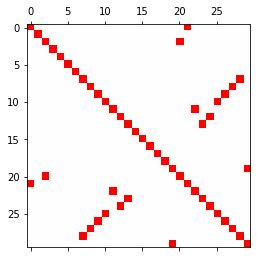

In [10]:
# Get distance function and expected distribution
from ipynb.fs.defs.covfit import inflated, naive
from scipy.stats import chi2

expected = chi2(df=K_DIM)

# Worst case covariance
cov_worst = np.full((N_DIM, N_DIM), np.nan)
# block sizes, only applies to the "block" types of data!
for i, ni in enumerate(BLOCKS):
    bi = int(np.sum(BLOCKS[:i]))
    cov_worst[bi : bi + ni, bi : bi + ni] = np.eye(ni)

# Fill to match projection matrix
fill_max_correlation(cov_worst, P)

# Projected
cov_worst_p = Q @ cov_worst @ Q.T

vm = np.max(np.abs(cov_worst))
plt.matshow(cov_worst, vmin=-vm, vmax=vm, cmap="bwr")
#print(cov_worst)

# Get worst case distances
data_worst = np.random.default_rng().multivariate_normal(
    mean=np.zeros(K_DIM), cov=cov_worst_p, size=N_POINTS * 4
)
dist_worst = naive(data_worst)


# Try to be conservative up to N sigma effects
sigma_crit = 3
p_crit = chi2.sf(sigma_crit**2, df=1)
x_crit_worst = np.quantile(dist_worst, 1.0 - p_crit)
x_crit_prime = chi2.isf(p_crit, df=K_DIM)
alpha = x_crit_worst / x_crit_prime
# alpha = 1.
print(sigma_crit, p_crit, x_crit_prime, alpha, np.sqrt(alpha))

del data_worst

dist = lambda x: inflated(x, alpha=alpha)
dname = "projected"

In [7]:
# Compute distances
distances = {}
for name, data in p_datasets.items():
    distances[name] = dist(data)

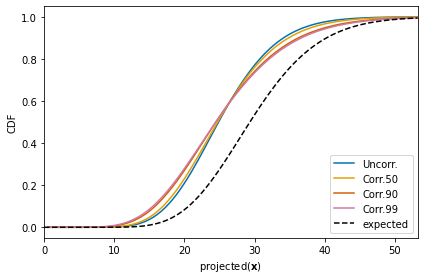

In [8]:
# Compare cumulative distributions
fig, ax = plt.subplots()
x = np.linspace(0, expected.mean() + expected.std() * 3, 100)
for name in datasets:
    tot = len(distances[name])
    count, bins = np.histogram(distances[name], bins=x)
    cdf = np.cumsum(count) / tot
    ax.plot(x[1:], cdf, label=name)
ax.plot(x, expected.cdf(x), label=f"expected", linestyle="dashed")
# ax.plot(
#    x,
#    chi2(df=1).cdf(x / N_DIM * alpha),
#    label=rf"$\chi^2_1 \times {N_DIM} / {alpha:0.1f}$",
#    linestyle="dotted",
#    color="0.3",
# )
ax.set_xlim(0, expected.mean() + expected.std() * 3)
ax.set_xlabel(f"{dname}$(\mathbf{{x}})$")
ax.set_ylabel("CDF")
ax.legend(loc="lower right")
fig.tight_layout()
fig.savefig(f"plots/{dname}_cdf.pdf")

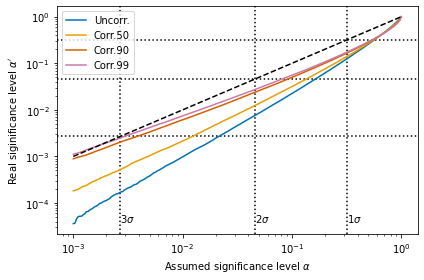

In [9]:
# siginifcance levels
fig, ax = plt.subplots()
for s in [1, 2, 3]:
    SL = chi2.sf(s**2, df=1)
    ax.axhline(SL, color="k", linestyle="dotted")
    ax.axvline(SL, color="k", linestyle="dotted")
    ax.annotate(f"${s}\sigma $ ", (SL, 0.05), xycoords=("data", "axes fraction"))

x = np.logspace(-3, 0, 200)
for name, data in distances.items():
    y = np.sum(data[:, np.newaxis] >= expected.isf(x), axis=0) / len(data)
    ax.plot(x, y, label=name)
ax.plot([1e-3, 1], [1e-3, 1], color="k", linestyle="dashed")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel(r"Real siginificance level $\alpha'$")
ax.set_xlabel(r"Assumed significance level $\alpha$")
ax.legend(loc="upper left")
fig.tight_layout()
fig.savefig(f"plots/{dname}_significance.pdf")